In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from classifiers import grid_search

Load the dataset and select the features and target to use for the classification.

In [3]:
import pandas as pd

df = pd.read_csv('../data/new_incidents.csv')

# drop useless columns
df = df.drop(columns=['notes', 'date'])

poverty_df = pd.read_csv('../data/poverty_cleaned.csv')
df = df.merge(poverty_df, on=['state', 'year'])

In [4]:
# convert state string to int
df['state'] = df['state'].astype('category')
df['state'] = df['state'].cat.codes

df['city_or_county'] = df['city_or_county'].astype('category')
df['city_or_county'] = df['city_or_county'].cat.codes

df['incident_category'] = df['incident_category'].astype('category')
df['incident_category'] = df['incident_category'].cat.codes

df["any_killed"] = df["n_killed"] > 0

df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159432 entries, 0 to 183652
Data columns (total 37 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   state                   159432 non-null  int8   
 1   city_or_county          159432 non-null  int16  
 2   latitude                159432 non-null  float64
 3   longitude               159432 non-null  float64
 4   congressional_district  159432 non-null  float64
 5   avg_age_participants    159432 non-null  float64
 6   n_participants_adult    159432 non-null  float64
 7   n_males                 159432 non-null  float64
 8   n_females               159432 non-null  float64
 9   n_killed                159432 non-null  int64  
 10  n_injured               159432 non-null  int64  
 11  n_arrested              159432 non-null  int64  
 12  n_unharmed              159432 non-null  int64  
 13  n_participants          159432 non-null  int64  
 14  year                    1

In [6]:
input_columns = ['state', 'city_or_county', 'year', 'month', 'n_participants',
                 'n_participants_adult', 'n_minors',
                 'n_males', 'n_females',
                 'povertyPercentage']

target_column = ['any_killed']

X = df[input_columns]
y = df[target_column]

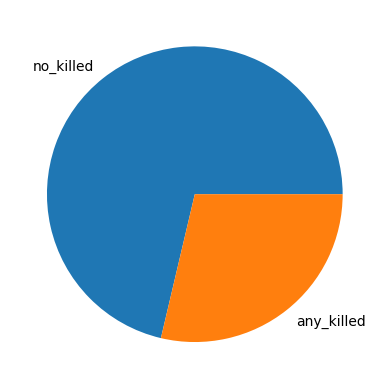

In [7]:
kill_value_count = df['any_killed'].value_counts()

labels = ['no_killed', 'any_killed']
plt.pie(kill_value_count, labels=labels)
plt.show()

Split the dataset into dev and test sets, then into train and validation (70/15/15). 

In [8]:
import numpy as np

seed = 42
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=seed, test_size=0.18, stratify=y_dev)

print('Dev set size:', len(y_dev), '- Killing ratio:', round(np.count_nonzero(y_dev) / len(y_dev), 2))
print('     Train set size:', len(y_train), '- Killing ratio:', round(np.count_nonzero(y_train) / len(y_train), 2))
print('     Validation set size:', len(y_val), '- Killing ratio:', round(np.count_nonzero(y_val) / len(y_val), 2))
print('Test set size:', len(y_test), '- Killing ratio:', round(np.count_nonzero(y_test) / len(y_test), 2))

Dev set size: 135517 - Killing ratio: 0.29
     Train set size: 111123 - Killing ratio: 0.29
     Validation set size: 24394 - Killing ratio: 0.29
Test set size: 23915 - Killing ratio: 0.29


Standardize the input data to avoid the bias given by the range of the different attribute

In [9]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

# ravel() is used to convert the y arrays from 2D to 1D
y_dev = y_dev.values.ravel()
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()


# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

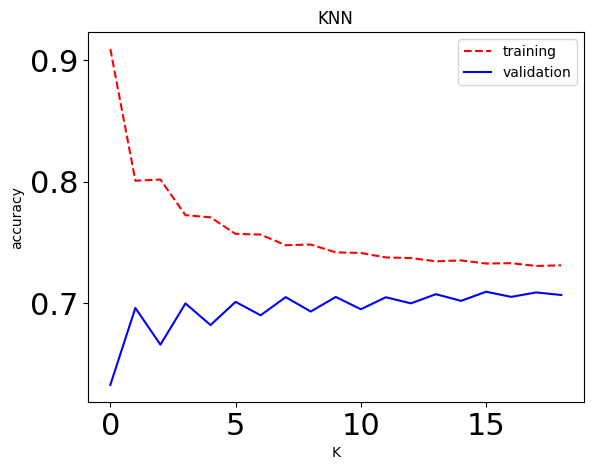

In [17]:
knn_list = []
acc_tr_list = []
acc_val_list = []

for x in range(1, 20):
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=x)
    knn.fit(X_std_train, y_train.values.ravel())
    acc_tr = knn.score(X_std_train, y_train)
    acc_val = knn.score(X_std_val, y_val)
    # append results
    knn_list.append(knn)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-', label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
# plt.axvline(10)
plt.legend(loc="upper right")
plt.show()

# Bayesian Classifier

In [22]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

gnb = GaussianNB()
y_pred_val = gnb.fit(X_std_train, y_train).predict(X_std_val)
print(classification_report(y_pred_val, y_val, target_names=labels))

              precision    recall  f1-score   support

  any_killed       0.91      0.72      0.81     21761
   no_killed       0.14      0.38      0.21      2633

    accuracy                           0.69     24394
   macro avg       0.53      0.55      0.51     24394
weighted avg       0.82      0.69      0.74     24394


In [23]:
bnb = BernoulliNB()
y_pred_val = bnb.fit(X_std_train, y_train).predict(X_std_val)
print(classification_report(y_pred_val, y_val, target_names=labels))

              precision    recall  f1-score   support

  any_killed       0.84      0.74      0.79     19729
   no_killed       0.27      0.41      0.33      4665

    accuracy                           0.68     24394
   macro avg       0.56      0.58      0.56     24394
weighted avg       0.73      0.68      0.70     24394


# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
best_score_dt, decision_tree = grid_search(DecisionTreeClassifier(), X_std_dev, y_dev, dt_params)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters set found:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Best accuracy score found:
0.714729513806289


# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}
best_score_rf, random_forest = grid_search(RandomForestClassifier(), X_std_dev, y_dev, rf_params)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters set found:
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
Best accuracy score found:
0.7223078968481818


# SVM

In [ ]:
from sklearn.svm import SVC

svm_params = {
    "kernel": ["rbf", "linear", "sigmoid"],
    "gamma": ["scale", "auto"],
    "C": [0.1, 1, 10]
}

best_score_svm, svm = grid_search(SVC(), X_std_dev, y_dev, svm_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


# Neural Network

In [11]:
from sklearn.neural_network import MLPClassifier

nn_params = {
    'hidden_layer_sizes': [25, 50, (50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001],
    'max_iter': [20, 50, 100]
}

best_score_nn, neural_network = grid_search(MLPClassifier(), X_std_dev, y_dev, nn_params)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters set found:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
Best accuracy score found:
0.7155043180850036


C:\Users\alext\Desktop\UniProjs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
